In [16]:
from multiprocessing import Pool
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

from ope.estimator_tuning import UserBehaviorTree
from ope.importance_weight import vanilla_weight, independent_weight, cascade_weight, adaptive_weight, inverse_cascade_weight
from dataset import SyntheticRankingBanditDataset
from ope.estimator import InversePropensityScore as IPS
from ope.meta import RankingOffPolicyEvaluation
from utils.util import aggregate_simulation_results, visualize_mean_squared_error
from utils.policy import gen_eps_greedy

In [2]:
def simulate_evaluation(args):
    ope_estimators, ope_estimators_tune, dataset, val_size, eps = args
    # generate synthetic data
    val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
    # evaluation policy
    evaluation_policy = gen_eps_greedy(expected_reward=val_data["evaluation_policy_logit"], eps=eps)
        
    # off policy evaluation
    ope = RankingOffPolicyEvaluation(
        bandit_feedback=val_data,
        ope_estimators=ope_estimators,
        ope_estimators_tune=ope_estimators_tune
    )
    estimated_policy_values = ope.estimate_policy_values(action_dist=evaluation_policy)
    
    return estimated_policy_values

In [20]:
# setting 1

# 変数
val_sizes=[1000, 2000, 3000, 4000, 5000]

# 定数
behavior_params = {"independent": 0.5, "cascade": 0.5, "standard": 1.0, "inverse_cascade": 1.5}
test_size=100000
n_sim=1000
dim_context=3
n_actions_at_k=2
len_list=5
beta=-1
eps=0.3
random_state=12345
interaction_noise=2
ope_estimators=[IPS(estimator_name="SIPS"), IPS(estimator_name="IIPS"), IPS(estimator_name="RIPS"), IPS(estimator_name="AIPS (true)")]

# tuning setting of the user behavior
param_name="estimated_user_behavior"
bias_estimation_method="experimental_on_policy"
weight_func=adaptive_weight
candidate_models={"independent": independent_weight, "cascade": cascade_weight, "standard": vanilla_weight, "inverse_cascade": inverse_cascade_weight}
val_size_bias_estimation=10000
n_partition=5
min_samples_leaf=100
n_bootstrap=10
max_depth=5

In [21]:
# experiment-1 varying data size under diverse user behaviors

dataset = SyntheticRankingBanditDataset(
    n_actions_at_k=n_actions_at_k,
    len_list=len_list,
    dim_context=dim_context,
    behavior_params=behavior_params,
    beta=beta,
    eps=eps,
    random_state=random_state,
    interaction_noise=interaction_noise
)
# calculate ground truth policy value
test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, is_online=True)
policy_value = test_data["expected_reward_factual"].sum(1).mean()

result_df_list = []
for val_size in val_sizes:
    
    ope_estimators_tune = [
        UserBehaviorTree(
            estimator=IPS(estimator_name="AIPS - tree"),
            param_name=param_name,
            bias_estimation_method=bias_estimation_method,
            dataset=dataset,
            weight_func=weight_func,
            candidate_models=candidate_models,
            eps=eps,
            val_size=val_size_bias_estimation,
            len_list=len_list,
            n_partition=n_partition,
            min_samples_leaf=min_samples_leaf,
            n_bootstrap=n_bootstrap,
            max_depth=max_depth
        )
    ]
    
    job_args = [(ope_estimators, ope_estimators_tune, dataset, val_size, eps) for _ in range(n_sim)]
    with Pool(cpu_count()-1) as pool:
        imap_iter = pool.imap(simulate_evaluation, job_args)
        tqdm_ = tqdm(imap_iter, total=n_sim, desc=f"val_size={val_size}...")
        result_list = list(tqdm_)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=1000...: 100% 1000/1000 [01:21<00:00, 12.24it/s]
val_size=2000...: 100% 1000/1000 [02:58<00:00,  5.61it/s]
val_size=3000...: 100% 1000/1000 [09:44<00:00,  1.71it/s]
val_size=4000...: 100% 1000/1000 [12:46<00:00,  1.31it/s]
val_size=5000...: 100% 1000/1000 [14:09<00:00,  1.18it/s]


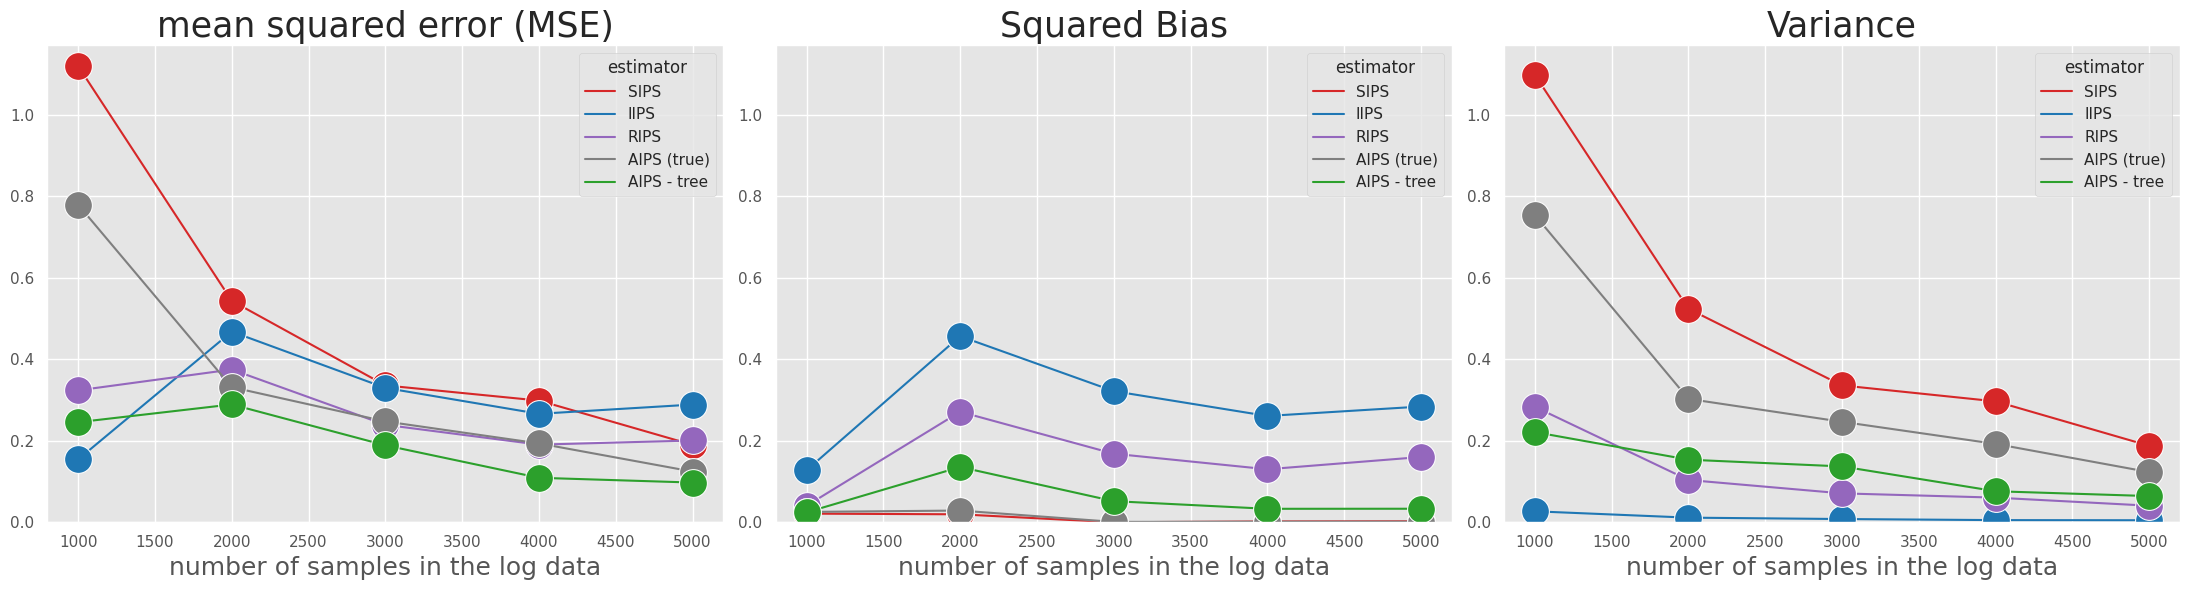

In [22]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of samples in the log data")

In [23]:
# setting 2

# 変数
len_list_list=[2, 4, 6, 8, 10, 12]

# 定数
behavior_params = {"independent": 0.5, "cascade": 0.5, "standard": 1.0, "inverse_cascade": 1.5}
test_size=100000
n_sim=1000
dim_context=3
n_actions_at_k=2
val_size=1000
beta=-1
eps=0.3
random_state=12345
interaction_noise=2.0
ope_estimators=[IPS(estimator_name="SIPS"), IPS(estimator_name="IIPS"), IPS(estimator_name="RIPS"), IPS(estimator_name="AIPS (true)")]

# tuning setting of the user behavior
param_name="estimated_user_behavior"
bias_estimation_method="experimental_on_policy"
weight_func=adaptive_weight
candidate_models={"independent": independent_weight, "cascade": cascade_weight, "standard": vanilla_weight, "inverse_cascade": inverse_cascade_weight}
val_size_bias_estimation=10000
n_partition=5
min_samples_leaf=100
n_bootstrap=10
max_depth=5

In [25]:
# experiment-2 varying len_list under diverse user behaviors

result_df_list = []
for len_list in len_list_list:
    
    dataset = SyntheticRankingBanditDataset(
        n_actions_at_k=n_actions_at_k,
        len_list=len_list,
        dim_context=dim_context,
        behavior_params=behavior_params,
        beta=beta,
        eps=eps,
        random_state=random_state,
        interaction_noise=interaction_noise
    )
    # calculate ground truth policy value
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, is_online=True)
    policy_value = test_data["reward"].sum(1).mean()
    
    ope_estimators_tune = [
        UserBehaviorTree(
            estimator=IPS(estimator_name="AIPS - tree"),
            param_name=param_name,
            bias_estimation_method=bias_estimation_method,
            dataset=dataset,
            weight_func=weight_func,
            candidate_models=candidate_models,
            eps=eps,
            val_size=val_size_bias_estimation,
            len_list=len_list,
            n_partition=n_partition,
            min_samples_leaf=min_samples_leaf,
            n_bootstrap=n_bootstrap,
            max_depth=max_depth
        )
    ]
    
    job_args = [(ope_estimators, ope_estimators_tune, dataset, val_size, eps) for _ in range(n_sim)]
    with Pool(cpu_count()-1) as pool:
        imap_iter = pool.imap(simulate_evaluation, job_args)
        tqdm_ = tqdm(imap_iter, total=n_sim, desc=f"len_list={len_list}...")
        result_list = list(tqdm_)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=len_list
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

len_list=2...: 100% 1000/1000 [01:11<00:00, 14.07it/s]
len_list=4...: 100% 1000/1000 [01:16<00:00, 13.09it/s]
len_list=6...: 100% 1000/1000 [01:25<00:00, 11.67it/s]
len_list=8...: 100% 1000/1000 [05:19<00:00,  3.13it/s]
len_list=10...: 100% 1000/1000 [05:32<00:00,  3.01it/s]
len_list=12...: 100% 1000/1000 [05:46<00:00,  2.89it/s]


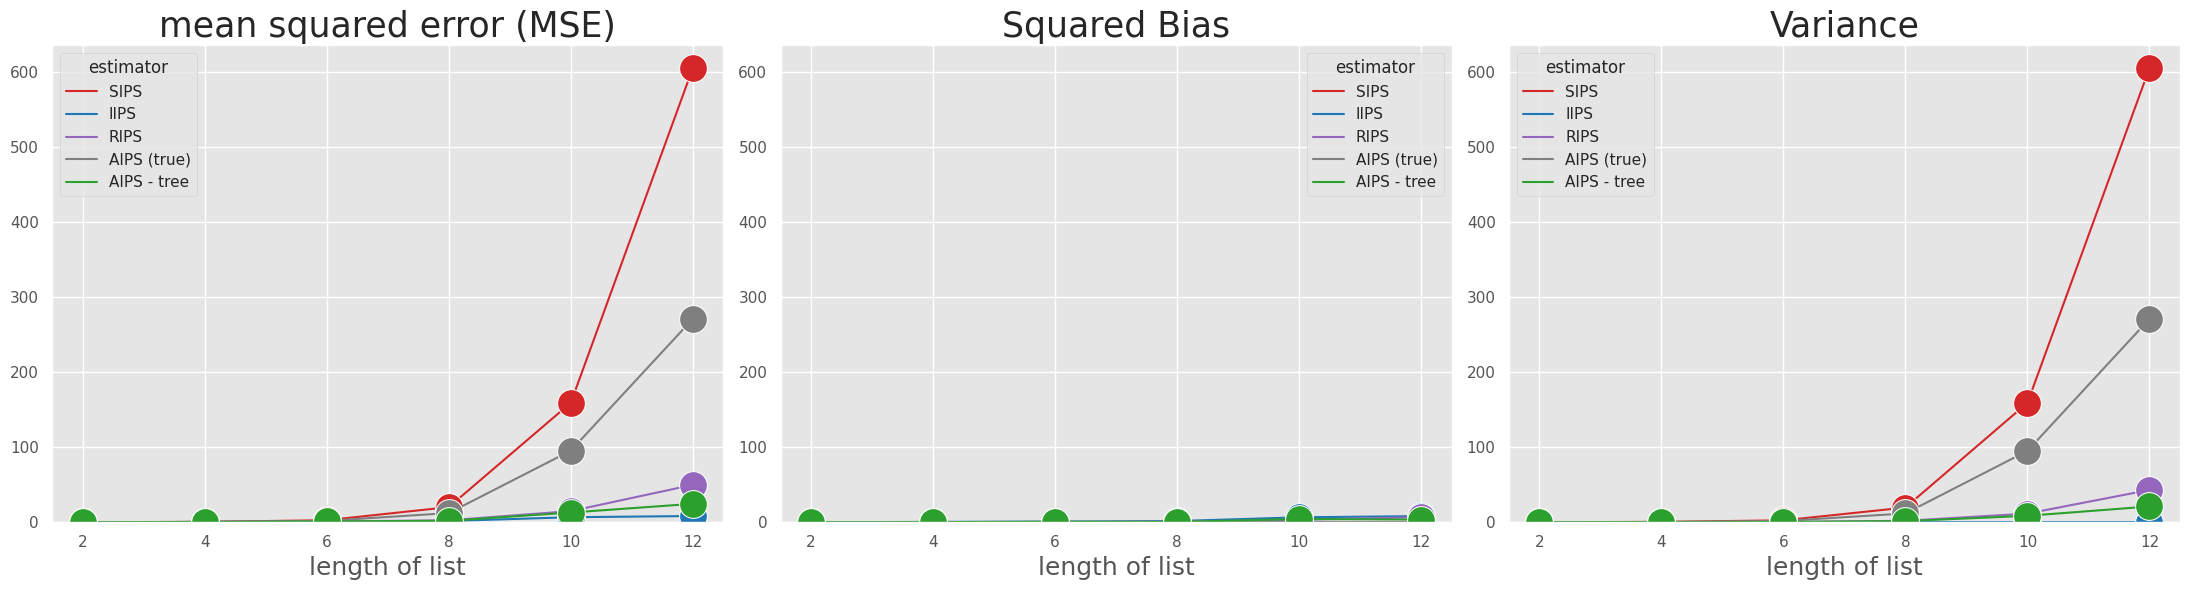

In [26]:
visualize_mean_squared_error(result_df=result_df, xlabel="length of list")

In [14]:
# setting 3

# 変数
val_sizes=[1000, 2000, 3000, 4000, 5000]

# 定数
behavior_params = {"top_2_cascade": 1.0, "neighbor_3": 1.0, "inverse_cascade": 2.0}
test_size=100000
n_sim=1000
dim_context=3
n_actions_at_k=2
len_list=7
beta=-1
eps=0.3
random_state=12345
interaction_noise=2
ope_estimators=[IPS(estimator_name="SIPS"), IPS(estimator_name="IIPS"), IPS(estimator_name="RIPS"), IPS(estimator_name="AIPS (true)")]

In [15]:
# experiment-3 varying data size under the (other) diverse user behavior

dataset = SyntheticRankingBanditDataset(
    n_actions_at_k=n_actions_at_k,
    len_list=len_list,
    dim_context=dim_context,
    behavior_params=behavior_params,
    beta=beta,
    eps=eps,
    random_state=random_state,
    interaction_noise=interaction_noise
)
# calculate ground truth policy value
test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, is_online=True)
policy_value = test_data["expected_reward_factual"].sum(1).mean()

result_df_list = []
for val_size in val_sizes:
    
    job_args = [(ope_estimators, None, dataset, val_size, eps) for _ in range(n_sim)]
    with Pool(cpu_count()-1) as pool:
        imap_iter = pool.imap(simulate_evaluation, job_args)
        tqdm_ = tqdm(imap_iter, total=n_sim, desc=f"val_size={val_size}...")
        result_list = list(tqdm_)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=1000...: 100% 1000/1000 [00:02<00:00, 488.87it/s]
val_size=2000...: 100% 1000/1000 [00:28<00:00, 34.84it/s]
val_size=3000...: 100% 1000/1000 [00:37<00:00, 26.89it/s]
val_size=4000...: 100% 1000/1000 [00:38<00:00, 25.73it/s]
val_size=5000...: 100% 1000/1000 [00:54<00:00, 18.31it/s]


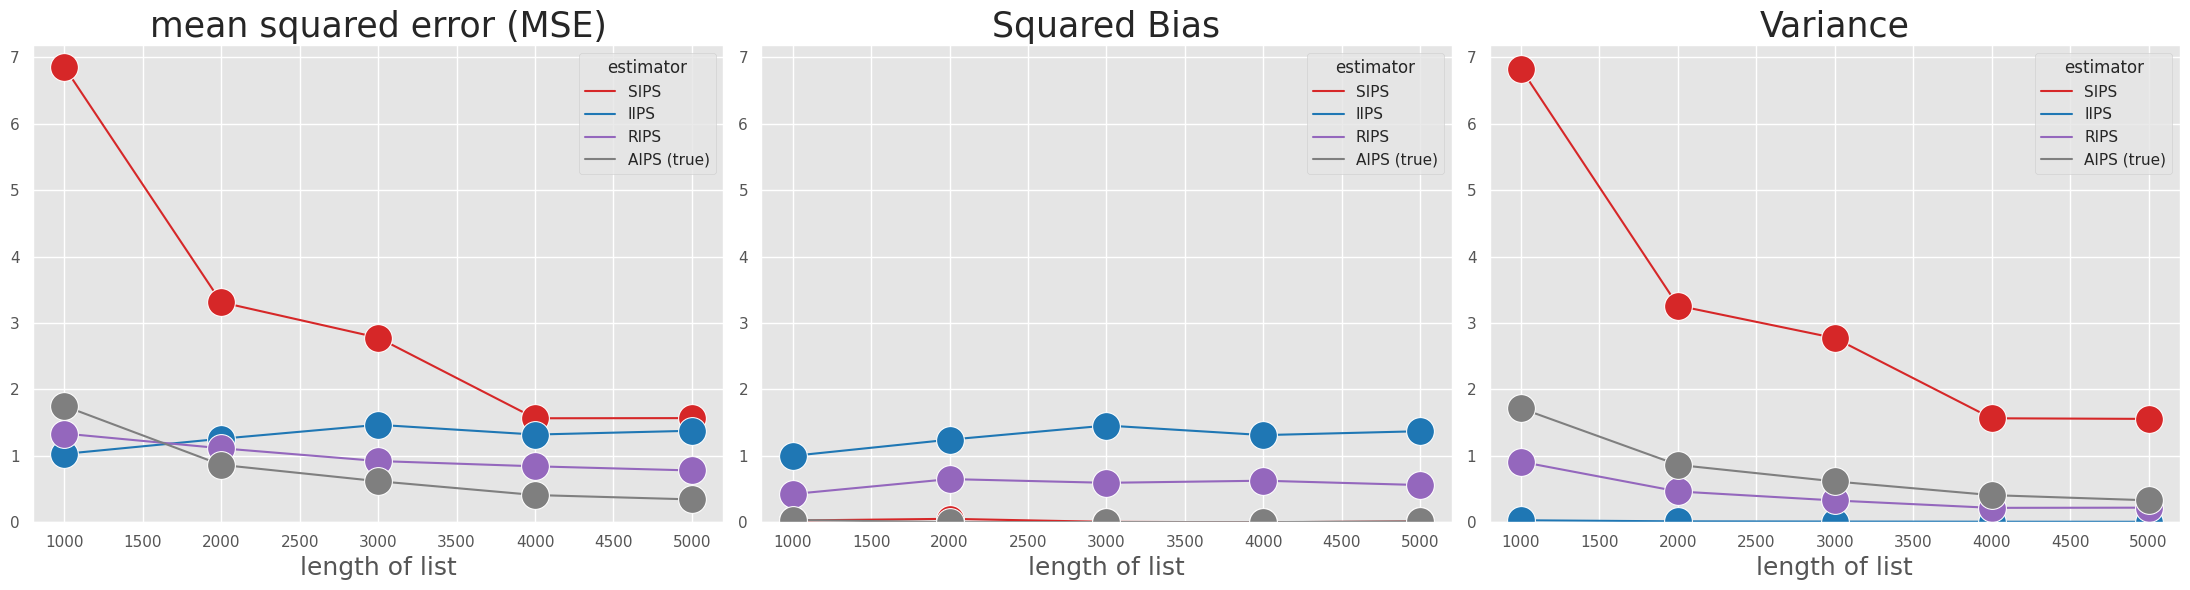

In [17]:
visualize_mean_squared_error(result_df=result_df, xlabel="length of list")